<a href="https://colab.research.google.com/github/md-marop-hossain/Ocular-Disease-Recognition-Project-CSE499A/blob/main/Ocular_Disease_Recognition_using_InceptionV3_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marophossain","key":"206e13053b2e3ac5823141c913d03d77"}'}

In [ ]:
#create a kaggle folder
! mkdir ~/.kaggle

In [ ]:
#copy the kaggle .josn to folder created
! cp kaggle.json ~/.kaggle/

In [ ]:
#permission for the json the act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                                   title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                          Global Country Information Dataset 2023             23KB  2023-07-08 20:37:33          10788        421  1.0              
nelgiriyewithana/global-youtube-statistics-2023                       Global YouTube Statistics 2023                      60KB  2023-07-28 15:36:38           2923        117  1.0              
joebeachcapital/global-earth-temperatures                             Global Earth Temperatures                           33KB  2023-08-09 06:21:51            607         28  1.0              
joebeachcapital/top-500-hollywood-m

In [ ]:
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

 99% 1.61G/1.62G [00:20<00:00, 89.1MB/s]
100% 1.62G/1.62G [00:21<00:00, 82.8MB/s]


In [ ]:
! unzip ocular-disease-recognition-odir5k

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('/content/full_df.csv')
df.head(2)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg


In [ ]:
df.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [ ]:
df.columns = ['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus','Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', "normal",
                    "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other",'filepath', 'labels', 'target', 'filename']

In [ ]:
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,normal,diabetes,glaucoma,cataract,amd,hypertension,myopia,other,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


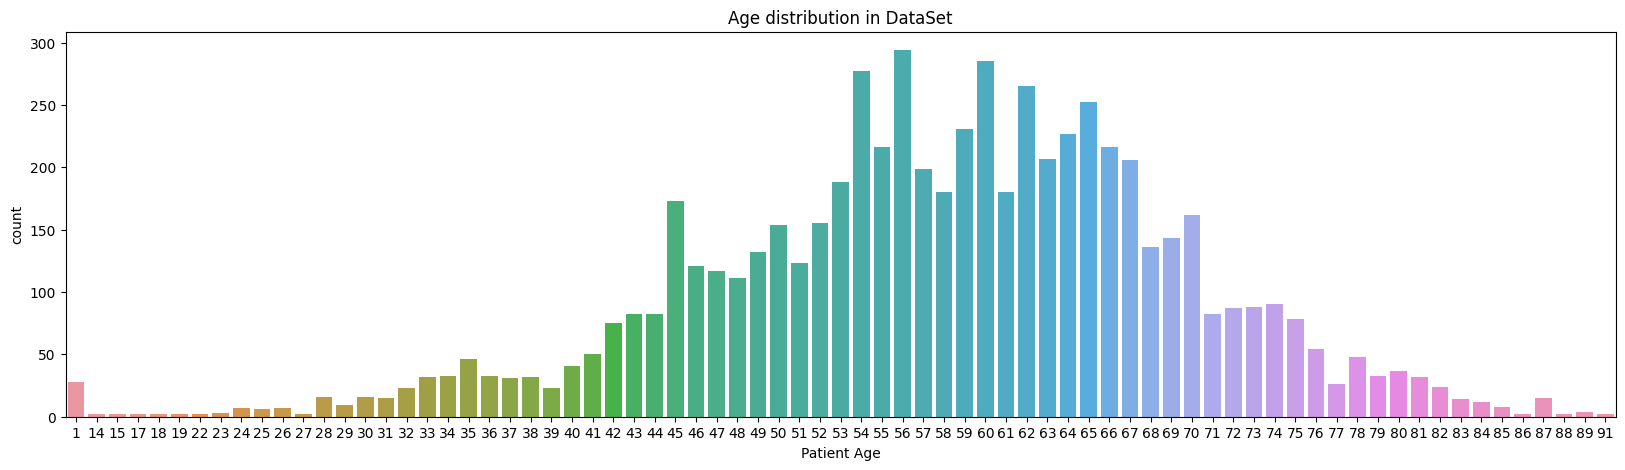

In [ ]:
import seaborn as sns
fig, (ax1) = plt.subplots(1, 1, figsize=(20,5))
sns.countplot(ax=ax1, x="Patient Age", data=df)
ax1.set_title("Age distribution in DataSet")
plt.show()

***we can see that the most affected are those in the age is between 45 and 70***

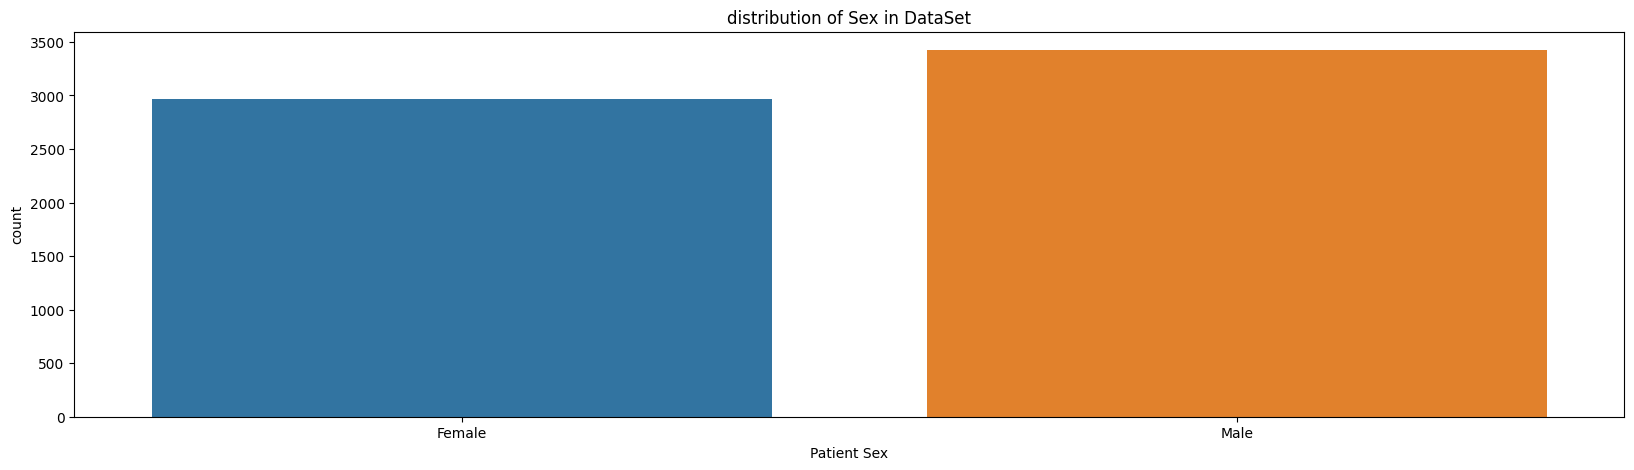

In [ ]:
import seaborn as sns
fit, (ax1) = plt.subplots(1, 1, figsize=(20, 5))
sns.countplot(ax = ax1, x = 'Patient Sex', data = df)
ax1.set_title('distribution of Sex in DataSet')
plt.show()

In [ ]:
df.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'normal',
       'diabetes', 'glaucoma', 'cataract', 'amd', 'hypertension', 'myopia',
       'other', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

**we can see that the most affected are the males**

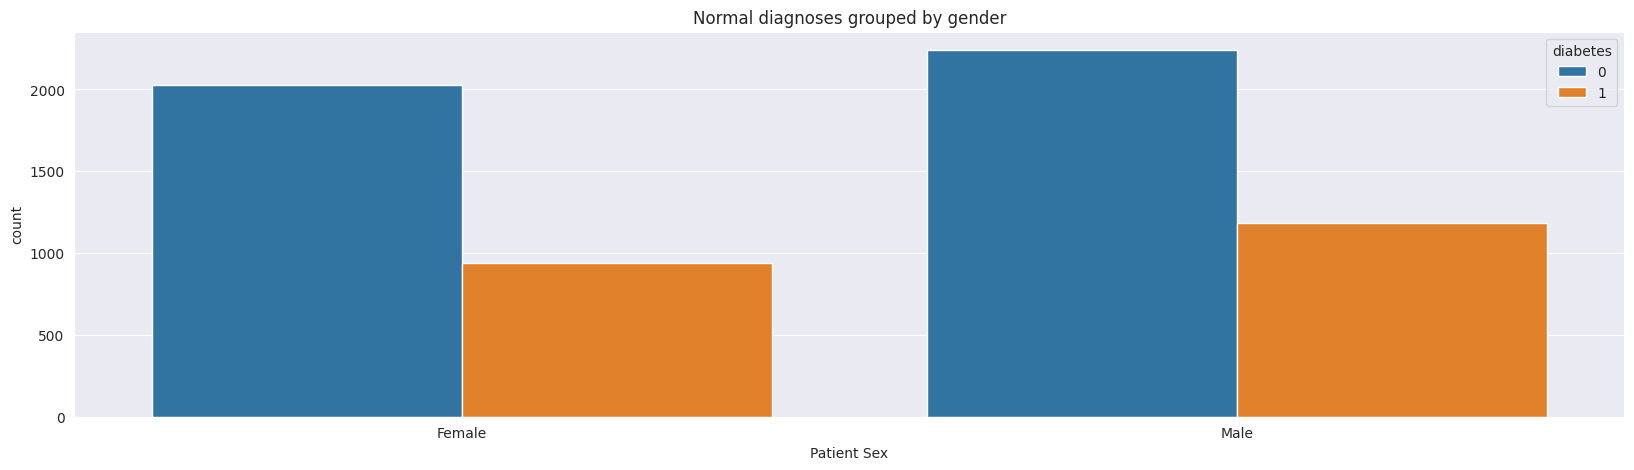

In [ ]:
sns.set_style("darkgrid")
fig= plt.subplots(figsize=(20,5))
sns.countplot(x='Patient Sex', hue="diabetes", data = df)
plt.title("Normal diagnoses grouped by gender")
plt.show()

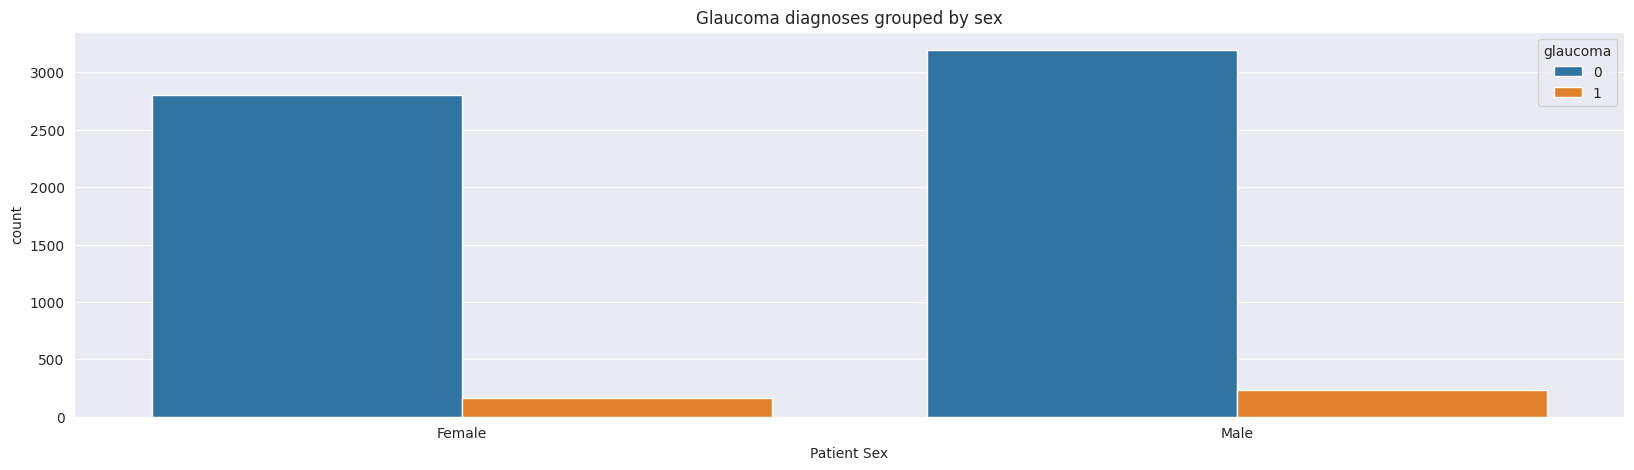

In [ ]:
sns.set_style("darkgrid")
fig= plt.subplots(figsize=(20,5))
sns.countplot(x='Patient Sex', hue="glaucoma", data = df)
plt.title("Glaucoma diagnoses grouped by sex")
plt.show()

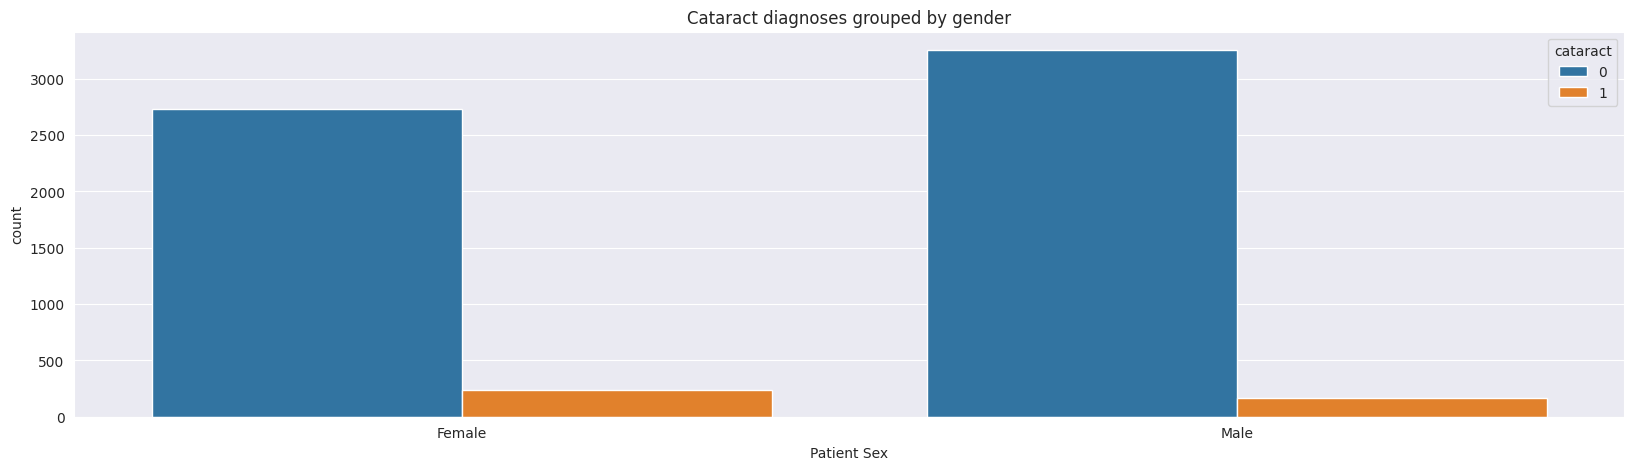

In [ ]:
sns.set_style("darkgrid")
fig= plt.subplots(figsize=(20,5))
sns.countplot(x='Patient Sex', hue="cataract", data = df)
plt.title("Cataract diagnoses grouped by gender")
plt.show()

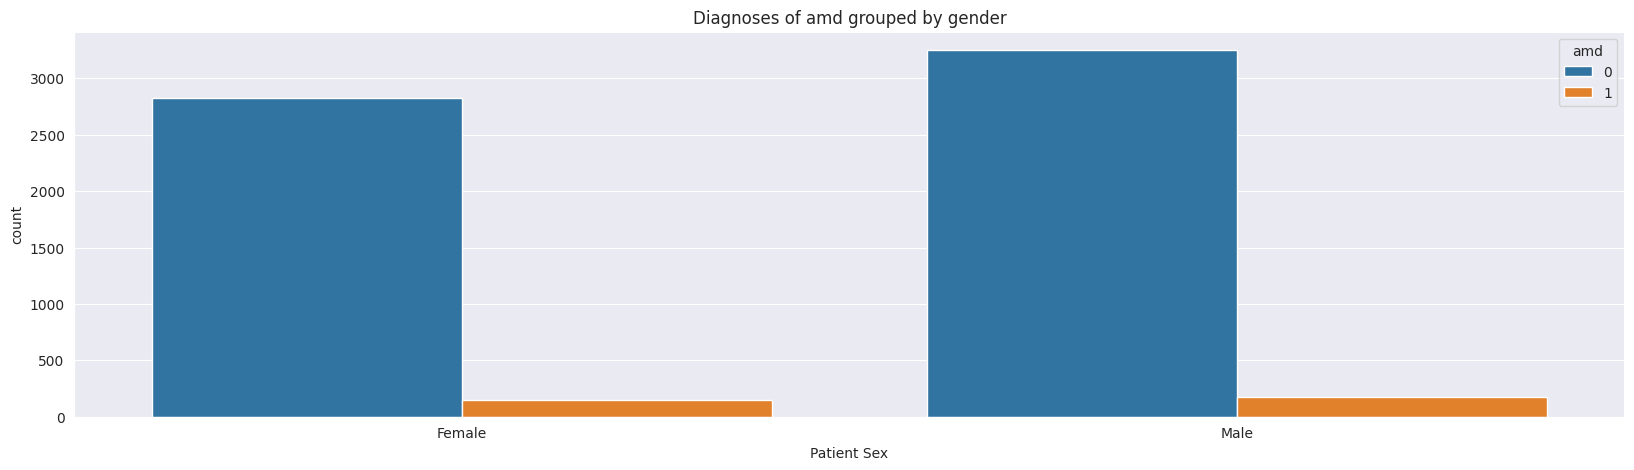

In [ ]:
sns.set_style("darkgrid")
fig= plt.subplots(figsize=(20,5))
sns.countplot(x='Patient Sex', hue="amd", data=df)
plt.title("Diagnoses of amd grouped by gender")
plt.show()

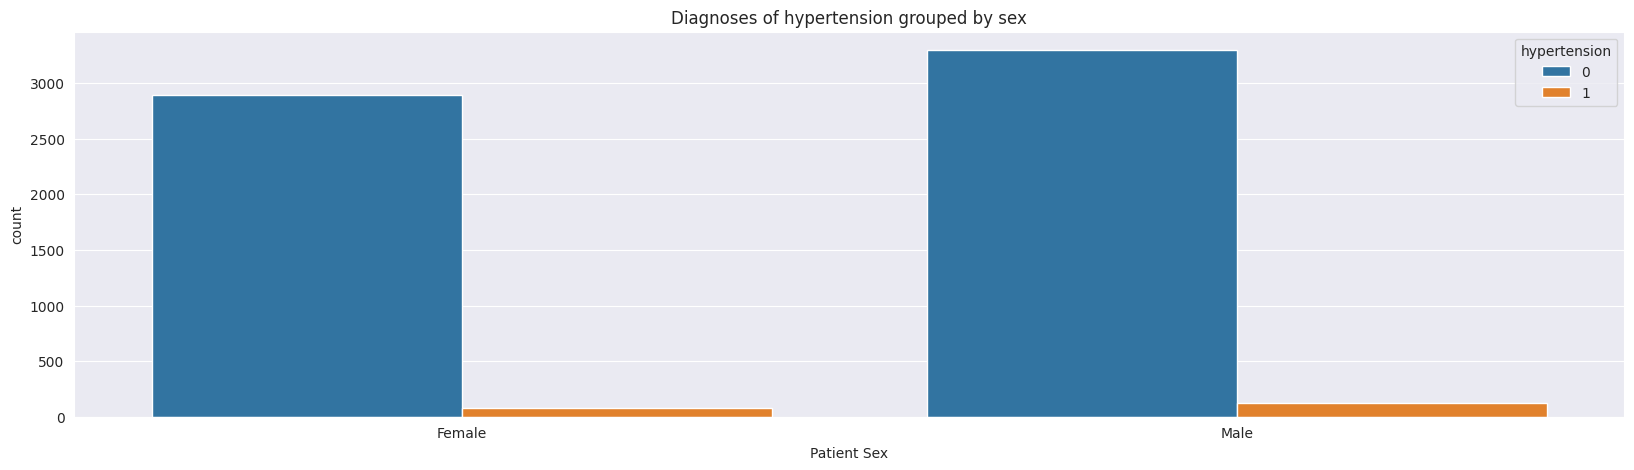

In [ ]:
sns.set_style("darkgrid")
fig= plt.subplots(figsize=(20,5))
sns.countplot(x='Patient Sex', hue="hypertension", data=df)
plt.title("Diagnoses of hypertension grouped by sex")
plt.show()

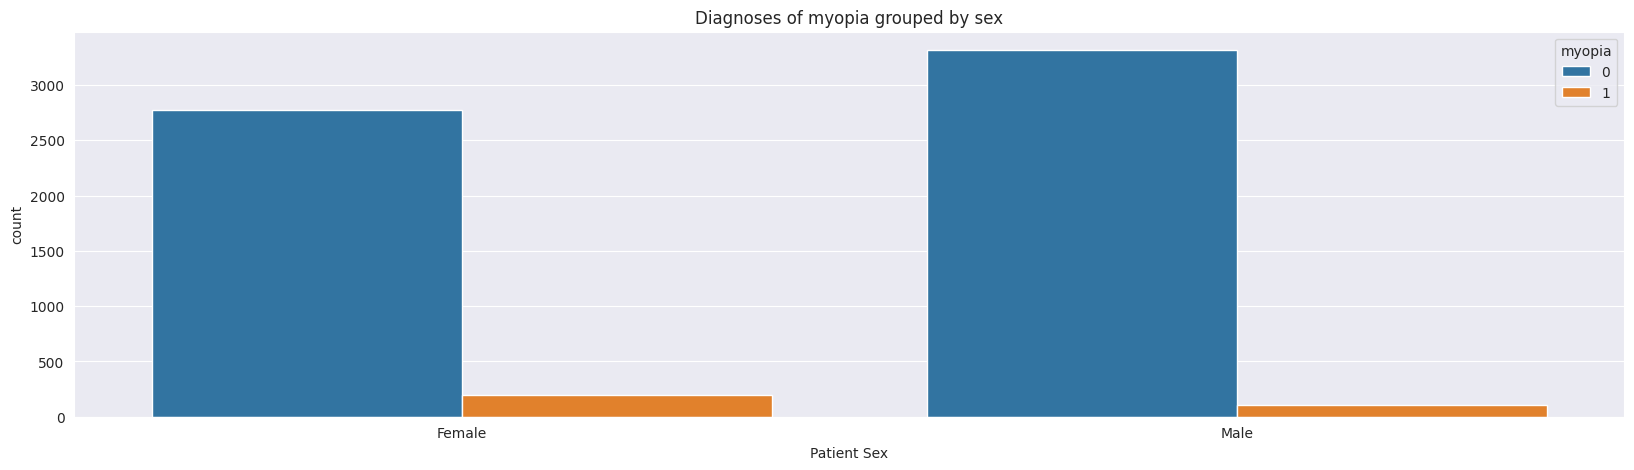

In [ ]:
sns.set_style("darkgrid")
fig= plt.subplots(figsize=(20,5))
sns.countplot(x='Patient Sex', hue="myopia", data=df)
plt.title("Diagnoses of myopia grouped by sex")
plt.show()

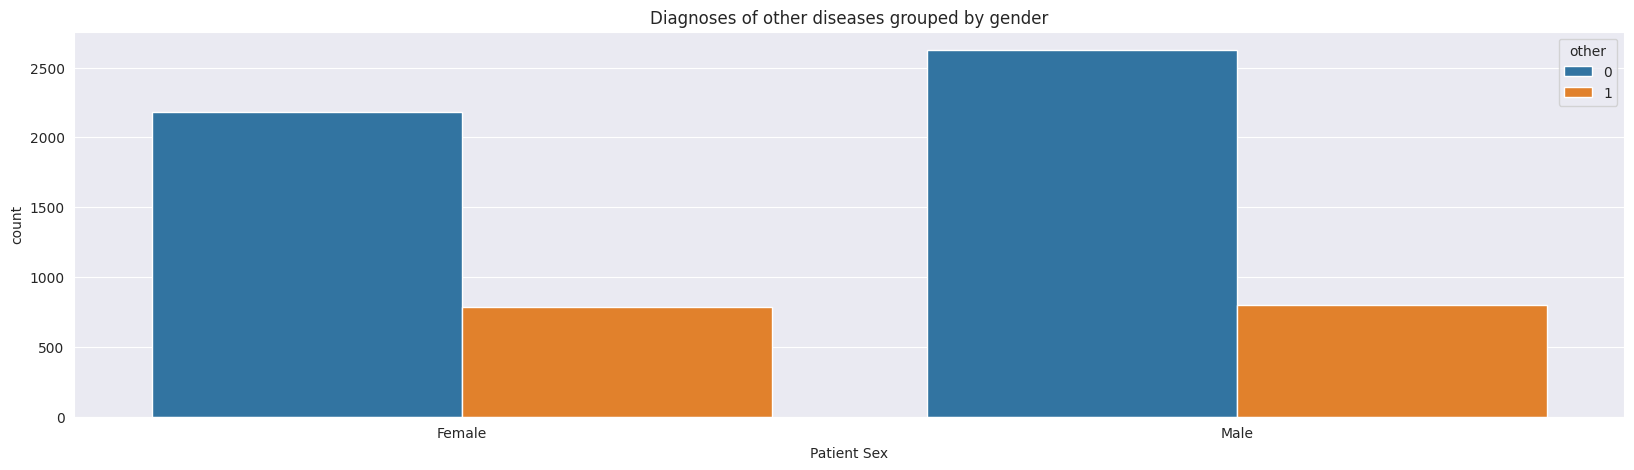

In [ ]:
sns.set_style("darkgrid")
fig= plt.subplots(figsize=(20,5))
sns.countplot(x='Patient Sex', hue="other", data=df)
plt.title("Diagnoses of other diseases grouped by gender")
plt.show()

In [ ]:
df.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'normal',
       'diabetes', 'glaucoma', 'cataract', 'amd', 'hypertension', 'myopia',
       'other', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [ ]:
df.columns = df.columns.str.strip()

In [ ]:
print(df.columns)

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'normal',
       'diabetes', 'glaucoma', 'cataract', 'amd', 'hypertension', 'myopia',
       'other', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')


In [ ]:
print(df.shape)

(6392, 19)


In [ ]:
print(df['Left-Diagnostic Keywords'].unique())

['cataract' 'normal fundus'
 'laser spot，moderate non proliferative retinopathy'
 'macular epiretinal membrane' 'moderate non proliferative retinopathy'
 'drusen' 'epiretinal membrane'
 'moderate non proliferative retinopathy，hypertensive retinopathy'
 'pathological myopia' 'mild nonproliferative retinopathy'
 'hypertensive retinopathy'
 'macular epiretinal membrane，mild nonproliferative retinopathy'
 'macular hole' 'wet age-related macular degeneration'
 'moderate non proliferative retinopathy，laser spot'
 'moderate non proliferative retinopathy，myelinated nerve fibers'
 'dry age-related macular degeneration'
 'epiretinal membrane，myelinated nerve fibers' 'diabetic retinopathy'
 'epiretinal membrane，lens dust' 'atrophy'
 'laser spot，white vessel，moderate non proliferative retinopathy'
 'chorioretinal atrophy' 'moderate non proliferative retinopathy，cataract'
 'retinitis pigmentosa'
 'moderate non proliferative retinopathy，retina fold'
 'normal fundus，lens dust' 'suspected glaucoma' 'v

In [ ]:
def plot_count(feature, title, df, size=1, show_all=False):
    f, ax = plt.subplots(1, 1, figsize=(4*size, 4))
    total = float(len(df))
    if show_all:
        g = sns.countplot(data=df, x=feature, palette='Set3')
        g.set_title("{} distribution".format(title))
    else:
        g = sns.countplot(data=df, x=feature, order=df[feature].value_counts().index[:20], palette='Set3')
        if size > 2:
            plt.xticks(rotation=90, size=8)
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x() + p.get_width() / 2.,
                        height + 0.2,
                        '{:1.2f}%'.format(100 * height / total),
                        ha="center")
        g.set_title("Number and percentage of {}".format(title))
    plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


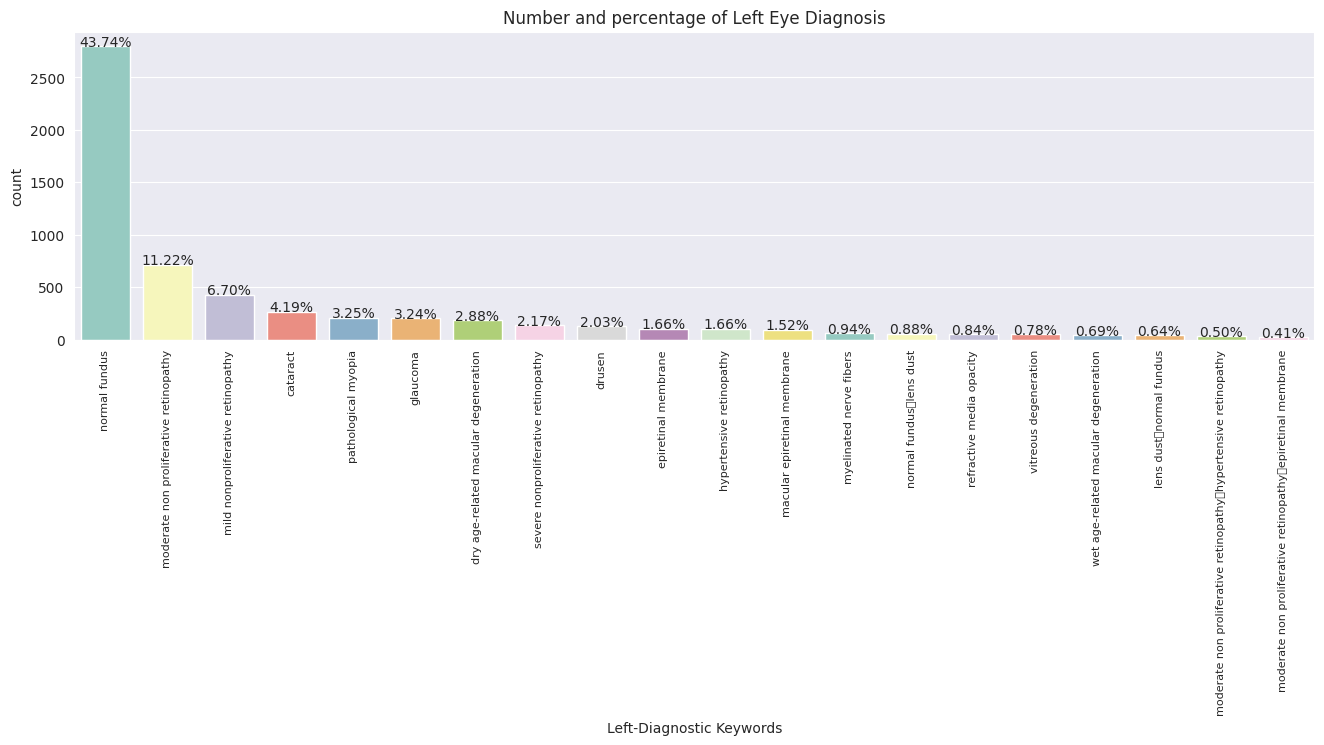

In [ ]:
plot_count('Left-Diagnostic Keywords', "Left Eye Diagnosis", df, size=4)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


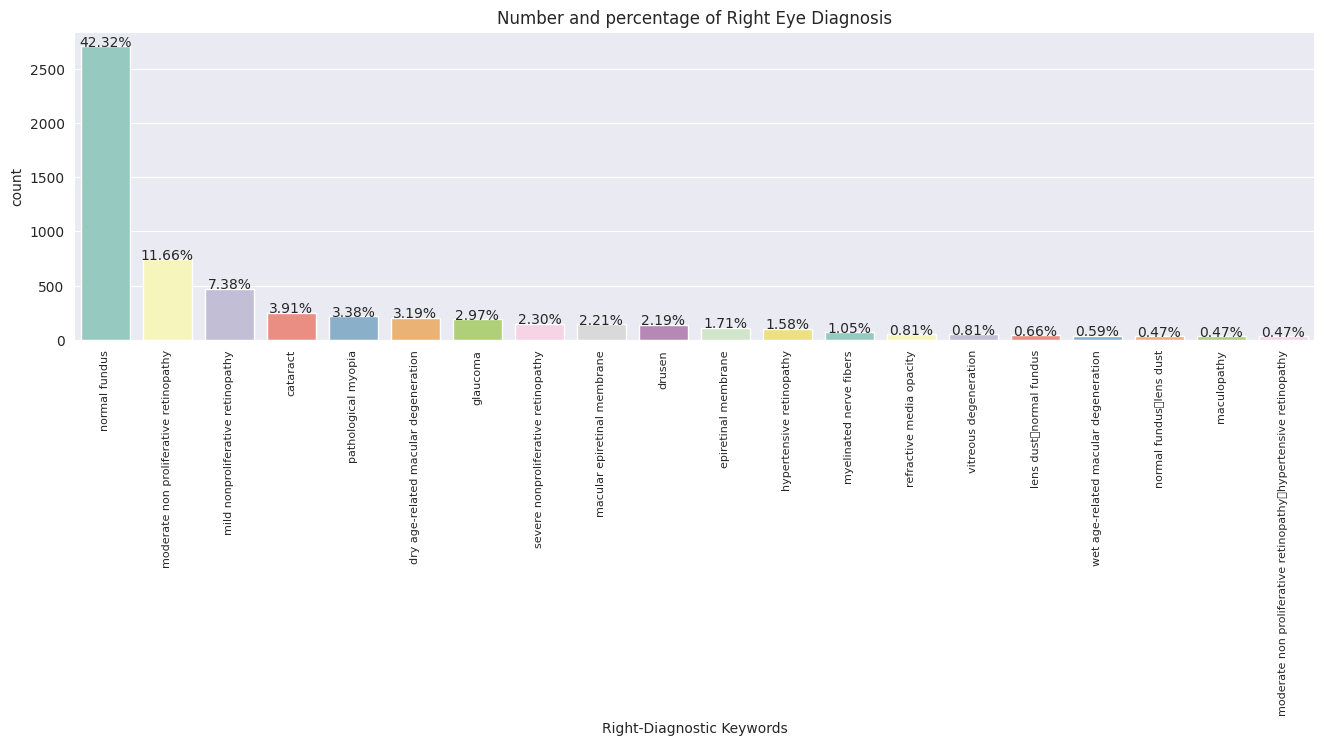

In [ ]:
plot_count('Right-Diagnostic Keywords', "Right Eye Diagnosis", df, size=4)

**Data Preprocessing:**

- - Define a function has_cataract that checks if "cataract" is present in the diagnostic keywords.
- - Create new columns "left_cataract" and "right_cataract" to mark whether cataract is present in the left and right eye images.

In [ ]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [ ]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [ ]:
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,normal,diabetes,glaucoma,...,amd,hypertension,myopia,other,filepath,labels,target,filename,left_cataract,right_cataract
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,1,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,0,0


**Data Selection:**



- - Select filenames of images with cataract and normal fundus for both left and right eyes.
- - Randomly sample 250 normal fundus images for both left and right eyes.

In [ ]:
df.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'normal',
       'diabetes', 'glaucoma', 'cataract', 'amd', 'hypertension', 'myopia',
       'other', 'filepath', 'labels', 'target', 'filename', 'left_cataract',
       'right_cataract'],
      dtype='object')

In [ ]:
left_cataract = df.loc[(df.cataract == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [ ]:
right_cataract = df.loc[(df.cataract == 1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [ ]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [ ]:
left_normal = df.loc[(df.cataract == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
len(left_normal)

250

In [ ]:
right_normal = df.loc[(df.cataract == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

**Creating the Dataset:**

- - Concatenate the filenames of left and right eye images with cataract and normal fundus.
- - Define a function create_dataset that loads, resizes, and appends images to the dataset along with their corresponding labels.

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
print(len(cataract),len(normal))

594 500


**Load and Preprocess Images:**

- - Load and preprocess images using OpenCV, resizing them to the specified image_size (224x224 pixels).
- - Create a dataset containing image arrays and their corresponding labels (0 for normal, 1 for cataract).

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import cv2
import numpy as np
from tqdm import tqdm
import random

# Directory where the preprocessed images are stored
dataset_dir = "/content/preprocessed_images"

# Desired size for images (both width and height)
image_size = 224

# Lists to store labels and the dataset
labels = []
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    # Iterate through each image in the provided image_category list
    for img in tqdm(image_category):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, img)

        try:
            # Load the image using OpenCV
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            # Resize the image to the desired size
            image = cv2.resize(image, (image_size, image_size))
            image = image / 255.0  # Scale pixel values to [0, 1]

        except:
            # Skip the image if there's an error (e.g., loading, resizing)
            continue

        # Append the image and its label as a tuple to the dataset list
        dataset.append([np.array(image), np.array(label)])

    # Shuffle the dataset randomly
    random.shuffle(dataset)
    return dataset

In [ ]:
# Create the cataract and normal datasets
dataset = create_dataset(cataract, 1)

100%|██████████| 594/594 [00:04<00:00, 119.27it/s]


In [ ]:
dataset[0][0].shape

(224, 224, 3)

In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:03<00:00, 143.18it/s]


In [ ]:
len(dataset)

1088

In [ ]:
dataset[30][1]

array(0)

**Visualize Sample Images:**

- - Visualize a subset of images from the dataset along with their labels.

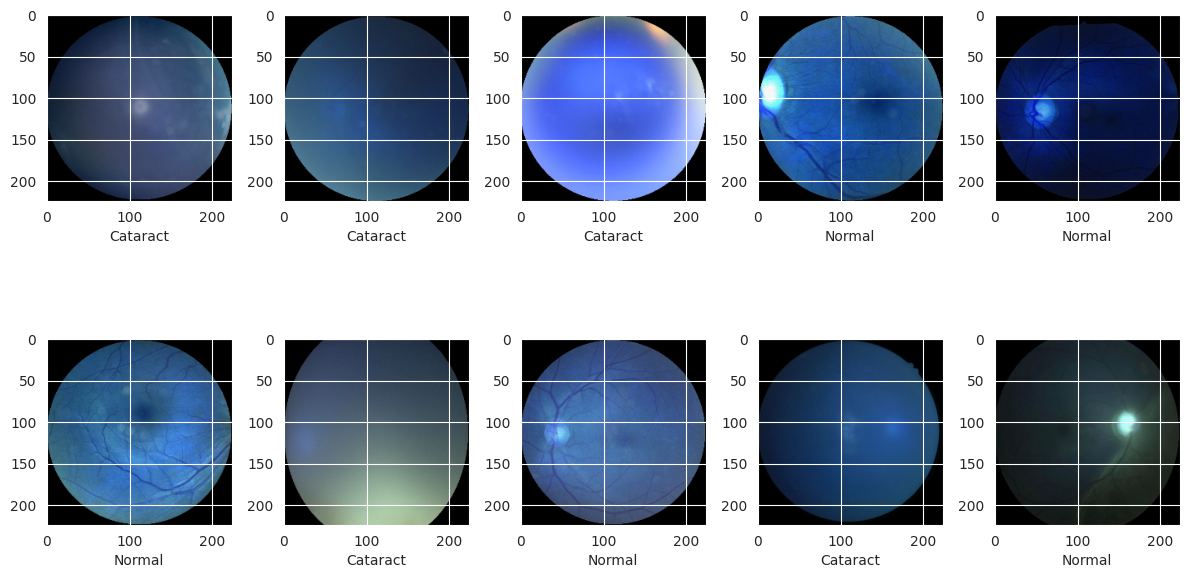

In [ ]:
import matplotlib.pyplot as plt
import random

# Set the size of the overall figure
plt.figure(figsize=(12, 7))

# Iterate over a range of 10 (to show 10 images in a 2x5 grid)
for i in range(10):
    # Randomly select an index from the dataset
    sample = random.choice(range(len(dataset)))

    # Extract the image and its label from the dataset
    image = dataset[sample][0]
    category = dataset[sample][1]

    # Convert the numeric label to a human-readable label
    if category == 0:
        label = "Normal"
    else:
        label = "Cataract"

    # Create a subplot within the grid (2 rows, 5 columns)
    plt.subplot(2, 5, i+1)

    # Display the image in the subplot
    plt.imshow(image)

    # Set the label as the x-axis label for the subplot
    plt.xlabel(label)

# Adjust the layout of subplots to prevent overlapping
plt.tight_layout()

# Show the figure with the grid of subplots
plt.show()


**Prepare Data for Model:**

- - Create numpy arrays x and y to store the image data and labels, respectively.
- - Split the data into training and testing sets using train_test_split.

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,224,224,3)
x.shape

(1088, 224, 224, 3)

In [ ]:
y = np.array([i[1] for i in dataset])
y.shape

(1088,)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(870, 224, 224, 3)
(218, 224, 224, 3)
(870,)
(218,)


**Create and Compile the InceptionV3 Model:**
- - Create the InceptionV3 model, freeze its layers, and add my own dense layers for classification:

In [ ]:
image_size = 224

# Load the InceptionV3 model with pre-trained weights
inception = InceptionV3(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers of the InceptionV3 model
for layer in inception.layers:
    layer.trainable = False

# Build my own model on top of InceptionV3
model = Sequential()
model.add(inception)
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.summary()

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


**Train the Model:**
- - Train the model with the training data and perform early stopping to prevent overfitting:

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("inceptionv3.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, period=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 0.8263 - accuracy: 0.8839
Epoch 1: val_accuracy improved from -inf to 0.90367, saving model to inceptionv3.h5
28/28 [==============================] - 179s 6s/step - loss: 0.8263 - accuracy: 0.8839 - val_loss: 0.9843 - val_accuracy: 0.9037
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.9575
Epoch 2: val_accuracy improved from 0.90367 to 0.95413, saving model to inceptionv3.h5
28/28 [==============================] - 142s 5s/step - loss: 0.3155 - accuracy: 0.9575 - val_loss: 0.3232 - val_accuracy: 0.9541
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9782
Epoch 3: val_accuracy improved from 0.95413 to 0.97706, saving model to inceptionv3.h5
28/28 [==============================] - 143s 5s/step - loss: 0.0725 - accuracy: 0.9782 - val_loss: 0.1892 - val_accuracy: 0.9771
Epoch 4/15
28/28 [==============================] - ETA: 0s - loss: 0.

**Evaluate the Model:**
- - Evaluate the trained model's performance on the test set and generate a confusion matrix:

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

7/7 [==============================] - 38s 6s/step - loss: 0.1598 - accuracy: 0.9725
Loss: 0.1597694456577301
Accuracy: 0.9724770784378052


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict(x_test)

7/7 [==============================] - 30s 4s/step


In [ ]:
threshold = 0.5  # You can adjust this threshold based on your preference

# Convert continuous prediction scores to binary predictions
y_pred_binary = (y_pred > threshold).astype(int)
y_pred_binary = y_pred_binary.reshape(-1)
y_pred_binary

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1])

In [ ]:
y_test

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1])

In [ ]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       108
           1       0.96      0.99      0.97       110

    accuracy                           0.97       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.97      0.97      0.97       218



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

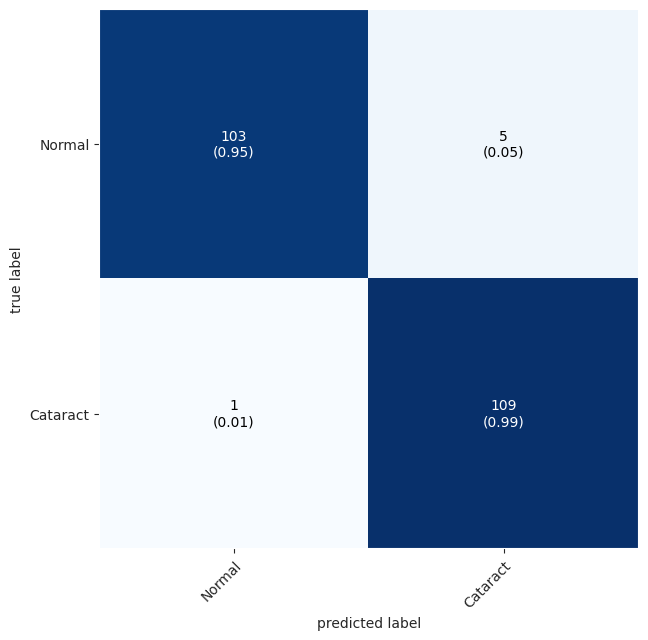

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Cataract"], show_normed=True)

**Learning curve:**

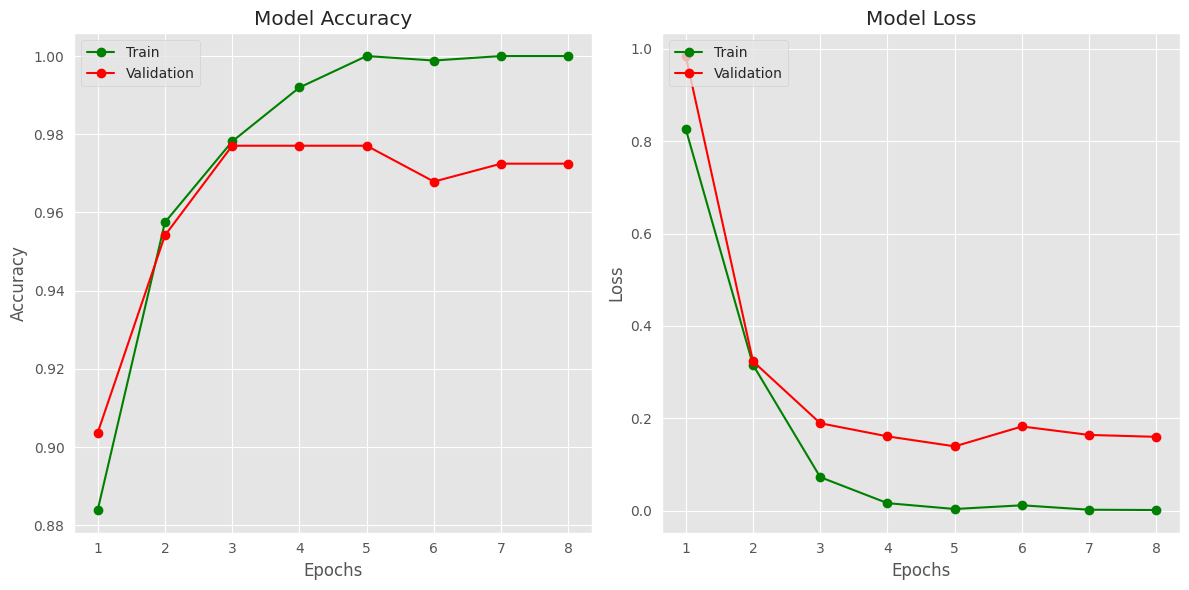

In [ ]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))

# Use the available epochs from history
epochs = range(1, len(history.history["accuracy"]) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-", label="Train")
plt.plot(epochs, history.history["val_accuracy"], "ro-", label="Validation")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-", label="Train")
plt.plot(epochs, history.history["val_loss"], "ro-", label="Validation")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()


**Build and Train the ResNet Model**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# Load the ResNet50 model
resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Set the layers in the ResNet model as non-trainable
for layer in resnet.layers:
    layer.trainable = False

# Build your model
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Define callbacks
checkpoint = ModelCheckpoint("resnet.h5", monitor="val_acc", verbose=1, save_best_only=True, save_weights_only=False, period=1)
earlystop = EarlyStopping(monitor="val_acc", patience=5, verbose=1)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint, earlystop])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


94765736/94765736 [==============================] - 1s 0us/step


Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 1.1472 - accuracy: 0.5368

28/28 [==============================] - 261s 9s/step - loss: 1.1472 - accuracy: 0.5368 - val_loss: 0.6681 - val_accuracy: 0.6101
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5690

28/28 [==============================] - 257s 9s/step - loss: 0.6857 - accuracy: 0.5690 - val_loss: 0.6995 - val_accuracy: 0.5046
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 0.8686 - accuracy: 0.5356

28/28 [==============================] - 253s 9s/step - loss: 0.8686 - accuracy: 0.5356 - val_loss: 1.4005 - val_accuracy: 0.5046
Epoch 4/15
28/28 [==============================] - ETA: 0s - loss: 0.8587 - accuracy: 0.5368

28/28 [==============================] - 253s 9s/step - loss: 0.8587 - accuracy: 0.5368 - val_loss: 0.8256 - val_accuracy: 0.5046
Epoch 5/15
28/28 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.6575

28/28 [==============================] - 256s 9s/step - loss: 0.6273 - accuracy: 0.6575 - val_loss: 0.5910 - val_accuracy: 0.7018
Epoch 6/15
28/28 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.6552

28/28 [==============================] - 258s 9s/step - loss: 0.6032 - accuracy: 0.6552 - val_loss: 0.7024 - val_accuracy: 0.5963
Epoch 7/15
28/28 [==============================] - ETA: 0s - loss: 0.7516 - accuracy: 0.5943

28/28 [==============================] - 255s 9s/step - loss: 0.7516 - accuracy: 0.5943 - val_loss: 0.5833 - val_accuracy: 0.6330
Epoch 8/15
28/28 [==============================] - ETA: 0s - loss: 0.5849 - accuracy: 0.6517

28/28 [==============================] - 258s 9s/step - loss: 0.5849 - accuracy: 0.6517 - val_loss: 0.6915 - val_accuracy: 0.5826
Epoch 9/15
28/28 [==============================] - ETA: 0s - loss: 0.6497 - accuracy: 0.5977

28/28 [==============================] - 264s 10s/step - loss: 0.6497 - accuracy: 0.5977 - val_loss: 0.7429 - val_accuracy: 0.5505
Epoch 10/15
28/28 [==============================] - ETA: 0s - loss: 0.5506 - accuracy: 0.7092

28/28 [==============================] - 256s 9s/step - loss: 0.5506 - accuracy: 0.7092 - val_loss: 0.7097 - val_accuracy: 0.5734
Epoch 11/15
28/28 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.6920

28/28 [==============================] - 254s 9s/step - loss: 0.5662 - accuracy: 0.6920 - val_loss: 0.5526 - val_accuracy: 0.6560
Epoch 12/15
28/28 [==============================] - ETA: 0s - loss: 0.5461 - accuracy: 0.7092

28/28 [==============================] - 255s 9s/step - loss: 0.5461 - accuracy: 0.7092 - val_loss: 0.5426 - val_accuracy: 0.7982
Epoch 13/15
28/28 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.7080

28/28 [==============================] - 253s 9s/step - loss: 0.5534 - accuracy: 0.7080 - val_loss: 0.6779 - val_accuracy: 0.5917
Epoch 14/15
28/28 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.6195

28/28 [==============================] - 253s 9s/step - loss: 0.6498 - accuracy: 0.6195 - val_loss: 0.6781 - val_accuracy: 0.5826
Epoch 15/15
28/28 [==============================] - ETA: 0s - loss: 0.6349 - accuracy: 0.6310

7/7 [==============================] - 43s 6s/step - loss: 0.5275 - accuracy: 0.8303
Loss: 0.527514636516571
Accuracy: 0.8302752375602722
